In [1]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import re

from os import listdir
from os.path import isfile, join

In [2]:
# get files
path='.'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f)) and f.startswith('out.perf.data')]


# order files
# get local, cstates and frequencies

prog = re.compile('^out\.perf\.data\.([a-z_]+)_callee\.state(\d+)\.(\d+)\.(\d+)\.(\d+)$')

caller_prog= re.compile('^\s+cond_wait\s+\d+\s+\[\d+\]\s+(.+):\s+sched:sched_waking\:.+cpu=(\d+)$')

callee_prog= re.compile('^\s+\S+\s+\d+\s+\[\d+\]\s+(.+):\s+power:cpu_idle\:\s*state\=(\d+).+$')

frequencies=[]
localities={}
states=[]

print(onlyfiles)

for f in onlyfiles:
    result = prog.match(f)
    if result == None:
        continue
    if result.group(1) not in localities:
        localities[result.group(1)]=[result.group(4),result.group(5)]
    if int(result.group(3)) not in frequencies:
        frequencies.append(int(result.group(3)))
    if int(result.group(2)) not in states:
        states.append(int(result.group(2)))
frequencies=sorted(frequencies)
print (localities)

# get caller / callee
results={}
for locality in localities:
    print(locality)
    results[locality]={}
    for state in states:
        results[locality][state]={}
        for frequency in frequencies:
            results[locality][state][frequency]={}
            # get the two files from onlyfiles
            for s in ['caller','callee']:
                x = [f for f in onlyfiles if f.startswith('out.perf.data.'+locality+'_'+s+'.state'+str(state)) and f.find(str(frequency)) != -1]
                results[locality][state][frequency][s]=x[0]
            # parse caller/callee
            caller_file=open(join(path, results[locality][state][frequency]['caller']))
            # parse caller/callee
            results[locality][state][frequency]['times']=[]
            callee_file=open(join(path, results[locality][state][frequency]['callee']))
            callee_times=[]
            callee_states=[]
            for callee_line in callee_file:
                result = callee_prog.match(callee_line)
                if result == None:
                    continue
                else:
                    callee_times.append(float(result.group(1)))
                    callee_states.append(int(result.group(2)))
            callee_file.close()
            last_index=10
            last_time=0
            #        print("read callee, now parse caller",caller_file)
            for line in caller_file:
                # parse the line
                result = caller_prog.match(line)
                if result == None:
                    continue
                # print ('matched1:', line)
                print(localities[locality], result.group(2))
                if int(result.group(2)) != int(localities[locality][1]):
                    continue
                caller_time=float(result.group(1))
                # print ('matched2:', line)
                last_time=caller_time
                # find the next time in callee
                last_index-=10
                for callee_time_index in range(last_index,len(callee_times)):
                    callee_time=callee_times[callee_time_index]
                    if callee_time >= caller_time:
                        last_index=callee_time_index
                        results[locality][state][frequency]['times'].append((callee_time-caller_time)*1000000)
                        break
                results[locality][state][frequency]['times']
#print(results)
print("Done")

['out.perf.data.local_callee.state1.1500000.8.9', 'out.perf.data.local_callee.state1.2200000.8.9', 'out.perf.data.local_callee.state1.2500000.8.9', 'out.perf.data.local_callee.state2.1500000.8.9', 'out.perf.data.local_callee.state2.2200000.8.9', 'out.perf.data.local_callee.state2.2500000.8.9', 'out.perf.data.local_caller.state1.1500000.8.9', 'out.perf.data.local_caller.state1.2200000.8.9', 'out.perf.data.local_caller.state1.2500000.8.9', 'out.perf.data.local_caller.state2.1500000.8.9', 'out.perf.data.local_caller.state2.2200000.8.9', 'out.perf.data.local_caller.state2.2500000.8.9', 'out.perf.data.remote_active_callee.state1.1500000.8.40', 'out.perf.data.remote_active_callee.state1.2200000.8.40', 'out.perf.data.remote_active_callee.state1.2500000.8.40', 'out.perf.data.remote_active_callee.state2.1500000.8.40', 'out.perf.data.remote_active_callee.state2.2200000.8.40', 'out.perf.data.remote_active_callee.state2.2500000.8.40', 'out.perf.data.remote_active_caller.state1.1500000.8.40', 'out.

Done


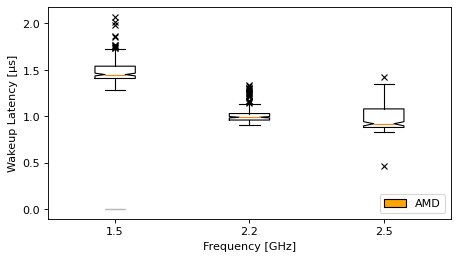

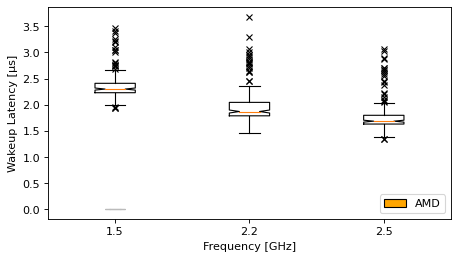

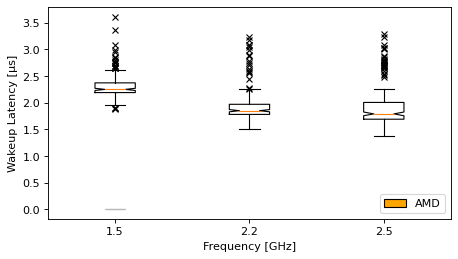

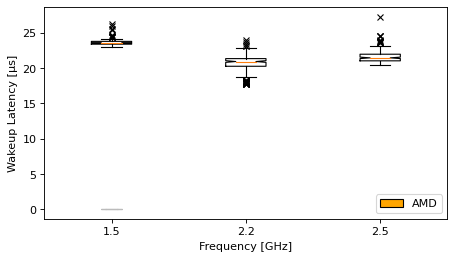

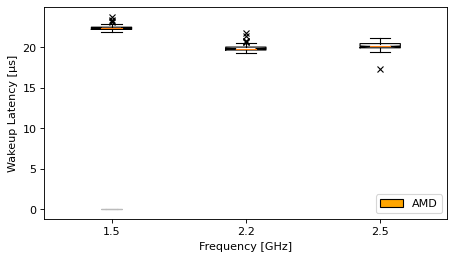

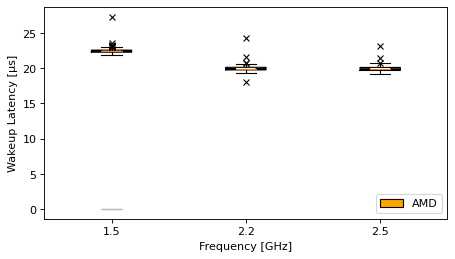

In [3]:
from matplotlib.pyplot import figure
from matplotlib.patches import Patch

for state in states:
    for locality in localities:
        figure(num=None, figsize=(6.5, 3.5), dpi=80, facecolor='w', edgecolor='k')
        lists=[]
        xs=[]
        for frequency in frequencies:
    #        print(locality,frequency,results[locality][frequency]['times'])
    #        plt.hist(results[locality][frequency]['times'], 100)
    #        plt.title(locality+','+str(frequency))
    #        plt.show()
            lists.append(results[locality][state][frequency]['times'])
            if ( frequency - 1000 ) % 100000 == 0:
                xs.append('Turbo')
            else:
                xs.append(frequency/1000000.0)
    #        print(len((results[locality][frequency]['times'])))
        plt.boxplot(lists,xs,sym='x') #,points=1000, widths=0.2, showmeans=True,showextrema=False, showmedians=True)

        lists=[]
        for frequency in frequencies:
            lists.append((0.0));
        c='#BBBBBB'
        plt.boxplot(lists,xs,sym='x',patch_artist=True, boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c)) #,points=1000, widths=0.2, showmeans=True,showextrema=False, showmedians=True)

        legend_elements = [
                       Patch(facecolor='orange', edgecolor='black',
                             label='AMD')]

        plt.legend(handles=legend_elements, loc='lower right')
    #    plt.ylim([0,60])
        plt.xticks(range(1,len(xs)+1),xs)
        plt.xlabel("Frequency [GHz]")
        plt.ylabel(r'Wakeup Latency [µs]')
#        plt.show()
        plt.savefig('cstate_wakeup_'+locality+'_'+str(state)+'.pdf')

#        plt.show()
    
print("Done")

In [4]:
for frequency in frequencies:
    print(frequency, np.median(results['remote_active'][2][frequency]['times']), np.median(results['local'][2][frequency]['times']))

1500000 22.39499008283019 23.52998126298189
2200000 19.844999769702554 20.920007955282927
2500000 20.119972759857774 21.440006094053388


In [5]:

for frequency in frequencies_diana:
    print(frequency, np.median(results_diana['local'][frequency]['times']))

NameError: name 'frequencies_diana' is not defined

In [6]:
import pandas as pd
import seaborn as sns
import subprocess
from matplotlib.backends.backend_pdf import PdfPages
from pylab import rcParams

In [7]:
def savefig(name, **kwargs):
    fn = "../../paper/fig/{}.pdf".format(name)
    pp = PdfPages(fn)
    pp.savefig(dpi=1200, bbox_inches="tight", **kwargs)
    pp.close()
    print("saving and cropping ", fn)
    subprocess.run(["pdfcrop", fn, fn])

In [8]:
_frequency = "Frequency [GHz]"
_time = "Latency [μs]"
df_data = list()
for state in states:
    for locality in localities:
        for frequency in frequencies:
            for t in results[locality][state][frequency]['times']:
                df_data.append({
                    "state": state,
                    "locality": locality,
                    "frequency": frequency,
                    _frequency: "Turbo" if (frequency % 100000 == 1000) else frequency / 1000000,
                    _time: t
                })
df = pd.DataFrame(df_data)

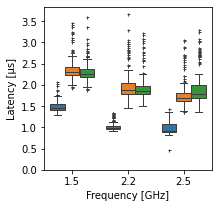

In [9]:
rcParams['figure.figsize'] = 3, 3
kwargs = {
    "flierprops": {
        "marker": "+",
        "markersize": 3,
        "markerfacecolor": "None",
        #"linestyle": "none"
    },
    "linewidth": 1.,
    "whis": 1.5,
}

sns.boxplot(
    data=df[df.state == 1],
    x=_frequency,
    y=_time,
    hue="locality",
    **kwargs
)
plt.gca().set_ylim(0)
plt.gca().get_legend().remove()

(0.0, 27.76599721983075)

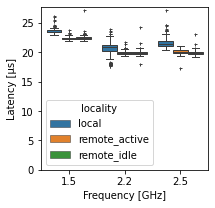

In [10]:
sns.boxplot(
    data=df[df.state == 2],
    x=_frequency,
    y=_time,
    hue="locality",
    **kwargs
)
plt.gca().set_ylim(0)

saving and cropping  ../../paper/fig/cstate_wakeup_local_1_sns.pdf


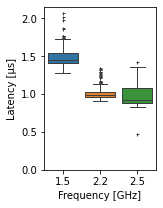

In [15]:
rcParams['figure.figsize'] = 2, 3


parameters = {
          'axes.labelsize': 10,
          'axes.titlesize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'legend.fontsize' : 10,
          'legend.title_fontsize' : 10,}
plt.rcParams.update(parameters)

sns.boxplot(
    data=df[(df.state == 1) & (df.locality == "local")],
    x=_frequency,
    y=_time,
    **kwargs
)
plt.gca().set_ylim(0)
savefig("cstate_wakeup_local_1_sns")

saving and cropping  ../../paper/fig/cstate_wakeup_local_2_sns.pdf


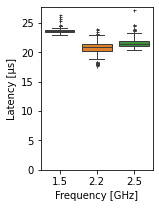

In [16]:
sns.boxplot(
    data=df[(df.state == 2) & (df.locality == "local")],
    x=_frequency,
    y=_time,
    **kwargs
)
plt.gca().set_ylim(0)
savefig("cstate_wakeup_local_2_sns")